In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
from PIL import Image

In [11]:
# Options being used 
batch_size = 100
imgDim = 28
path = './genImg/'
showPlot = False
savePlot = True
num_epochs = 200
IS_CUDA = False

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))])

In [12]:
# MNIST dataset
dataset = datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


In [13]:
# Helper routines
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def drawLossPlot(generatorLoss, discriminatorLoss, showPlot = False, savePlot = True, loc = "./"):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Vanilla GAN Loss')
    plt.plot(generatorLoss, label='Generator Loss')
    plt.plot(discriminatorLoss, label='Discriminator Loss')
    legend = plt.legend(loc='upper right', shadow=True)
    
    if showPlot:
        plt.show()
    if savePlot:
        plt.savefig(loc+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self):
        self.D_loss = []
        self.G_loss = []

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    

In [14]:
# Network
Generator_input = 64
Generator = nn.Sequential(
        nn.Linear(Generator_input, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 784),
        nn.Tanh())

Discriminator = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1),
        nn.Sigmoid())

if IS_CUDA:
    Discriminator.cuda()
    Generator.cuda()

In [15]:
lossCriterion = nn.BCELoss()
G_opt = torch.optim.Adam(Generator.parameters(), lr = 0.0002)
D_opt = torch.optim.Adam(Discriminator.parameters(), lr = 0.0002)
fixed_x = var(torch.randn(batch_size, Generator_input))
lossManager = LossModule()

In [16]:
outputImages = []
def train(num_epochs = 10, d_iter = 1):
    for epoch in range(num_epochs):
        for data in data_loader:
            image, _  = data
            image = var(image.view(image.size(0),  -1))
            # Train Discriminator
            
            #for k in range(0, d_iter):
            # For Log D(x)
            D_real = Discriminator(image)
            # For Log(1 - D(G(Z)))
            Z_noise = var(torch.randn(batch_size, Generator_input))
            G_fake = Generator(Z_noise)
            D_fake = Discriminator(G_fake)

            # Calculate Discriminator Loss
            D_real_loss = lossCriterion(D_real, var(torch.ones(batch_size, 1)))
            D_fake_loss = lossCriterion(D_fake, var(torch.zeros(batch_size, 1)))
            D_loss = D_real_loss + D_fake_loss

            # Backprop Discriminator
            Discriminator.zero_grad()
            D_loss.backward()
            D_opt.step()

                
            # Train Generator
            Z_noise = var(torch.randn(batch_size, Generator_input))
            G_fake = Generator(Z_noise)
            D_fake = Discriminator(G_fake)
            # Compute Generator Loss
            G_loss = lossCriterion(D_fake, var(torch.ones(batch_size, 1)))
            
            # Backprop Genearator
            Discriminator.zero_grad()
            Generator.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        #print epoch
        print 'Epoch [{}/{}], Discriminator {:.4f}, Generator {:.4f}'.format(epoch+1, num_epochs, D_loss.data[0], G_loss.data[0])
        lossManager.insertDiscriminatorLoss(D_loss.data[0])
        lossManager.insertGeneratorLoss(G_loss.data[0])
        pic = Generator(var(torch.randn(batch_size, Generator_input)))
        pic = pic.view(pic.size(0), 1, 28, 28) 
        pic = denorm(pic.data)
        outputImages.append(pic)
        #torchvision.utils.save_image(pic, path+'image_{}.png'.format(epoch))
        save_image(pic, path+'image_{}.png'.format(epoch))             

In [17]:
num_epochs = 200
train(num_epochs)

Epoch [1/200], Discriminator 0.7797, Generator 2.0178
Epoch [2/200], Discriminator 0.2843, Generator 2.9324
Epoch [3/200], Discriminator 0.6666, Generator 2.3162
Epoch [4/200], Discriminator 1.3680, Generator 1.1893
Epoch [5/200], Discriminator 0.3892, Generator 2.3045
Epoch [6/200], Discriminator 0.3572, Generator 2.7768
Epoch [7/200], Discriminator 0.3591, Generator 3.9963
Epoch [8/200], Discriminator 1.0963, Generator 1.9211
Epoch [9/200], Discriminator 0.4332, Generator 2.9338
Epoch [10/200], Discriminator 0.4454, Generator 3.0846
Epoch [11/200], Discriminator 0.2622, Generator 3.7821
Epoch [12/200], Discriminator 0.5792, Generator 2.2807
Epoch [13/200], Discriminator 0.6127, Generator 3.7278
Epoch [14/200], Discriminator 0.5283, Generator 3.3029
Epoch [15/200], Discriminator 0.7244, Generator 3.1555
Epoch [16/200], Discriminator 0.5314, Generator 2.7125
Epoch [17/200], Discriminator 0.5613, Generator 3.2017
Epoch [18/200], Discriminator 0.6763, Generator 1.8770
Epoch [19/200], Dis

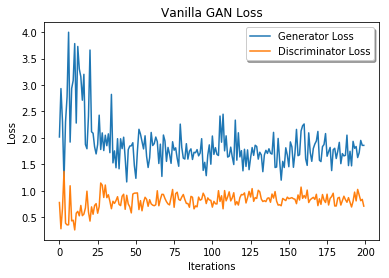

In [18]:
# Plot the Loss for Generator and Discriminator
drawLossPlot(lossManager.getGeneratorLoss(), lossManager.getDiscriminatorLoss(), showPlot = True, savePlot = False)

In [19]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Vanilla GAN')
plt.plot(lossManager.getGeneratorLoss(), label='Generator Loss')
plt.plot(lossManager.getDiscriminatorLoss(), label='Discriminator Loss')
legend = plt.legend(loc='upper right', shadow=True)
#plt.show()
plt.savefig('Loss_Plot_Vanilla_Min_GAN_'+str(num_epochs)+'.png')
#lossManager.drawLossPlot(showPlot = True, savePlot = False, genList = True)

In [60]:
# Generate GIF
generate_animation(path, num_epochs, 'Vanilla_Gan')

In [65]:
# Save the model
torch.save(Generator.state_dict(), './Generator.pkl')
torch.save(Discriminator.state_dict(), './Discriminator.pkl')
pickle.dump(lossManager, open( "LossManager.pkl", "wb" ))

In [74]:
# Load Loss Manager for viewing data of 200 iterations
#lossManagerTrained = pickle.load(open( "200Iteration/LossManager.pkl", "rb" ))

In [87]:
drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = False, savePlot = True, loc = "200Iteration")
#drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = True, savePlot = False, loc = "200Iteration")

In [2]:
# Load model for debugging and testing
#Generator.load_state_dict(torch.load('Generator200.pkl'))
#Discriminator.load_state_dict(torch.load('Discriminator200.pkl'))